<a href="https://colab.research.google.com/github/ggpal7117/Magnificent-Seven-Analysis-with-Python-and-Tableau/blob/main/Mags7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook will be the first part of scraping the necessary data for our tableau dashboard. This will be the first of two notebooks


In [1]:
!pip install stockdex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.0/512.0 kB 30.7 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.13.5
    Uninstalling beautifulsoup4-4.13.5:
      Successfully uninstalled beautifulsoup4-4.13.5
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: curl-cffi

In [2]:
# -- Import Libraries
import stockdex
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from stockdex.ticker import Ticker
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
MAG_7_TICKERS = ["MAGS", "GOOG", "AMZN", "AAPL", "META", "MSFT", "NVDA", "TSLA"]

In [4]:
# -- Get etf data
ticker = Ticker(ticker="MAGS")
mags_d = ticker.yahoo_api_price(range='5y', dataGranularity='1d')
mags_d = mags_d.set_index('timestamp')
mags_d["Symbol"] = "MAGS"

# When did the MAGS index begin trading
mags_first_date = mags_d.index.values[0]
mags_first_date

np.datetime64('2023-04-11T13:30:00.000000000')

In [5]:
# Get all stock data
mags = pd.DataFrame()
for ticker in MAG_7_TICKERS+["SPY"]:
    temp_ticker = Ticker(ticker=ticker)
    mags_temp = temp_ticker.yahoo_api_price(range='5y', dataGranularity='1d')
    mags_temp = mags_temp.set_index('timestamp')
    mags_temp = mags_temp[mags_first_date:"12/20/2025"]
    if ticker == "MAGS":
        mags_temp["Symbol"] = "Mags Index"
    else:
      mags_temp["Symbol"] = ticker

    mags = pd.concat([mags, mags_temp], axis=0)

In [6]:
# subset
close = mags[["Symbol", "close"]]
close

,Symbol,close
timestamp,,
2023-04-11 13:30:00,Mags Index,24.466000
2023-04-12 13:30:00,Mags Index,24.330000
2023-04-13 13:30:00,Mags Index,25.056999
2023-04-14 13:30:00,Mags Index,25.070000
2023-04-17 13:30:00,Mags Index,24.955999
...,...,...
2025-12-15 14:30:00,SPY,680.729980
2025-12-16 14:30:00,SPY,678.869995
2025-12-17 14:30:00,SPY,671.400024


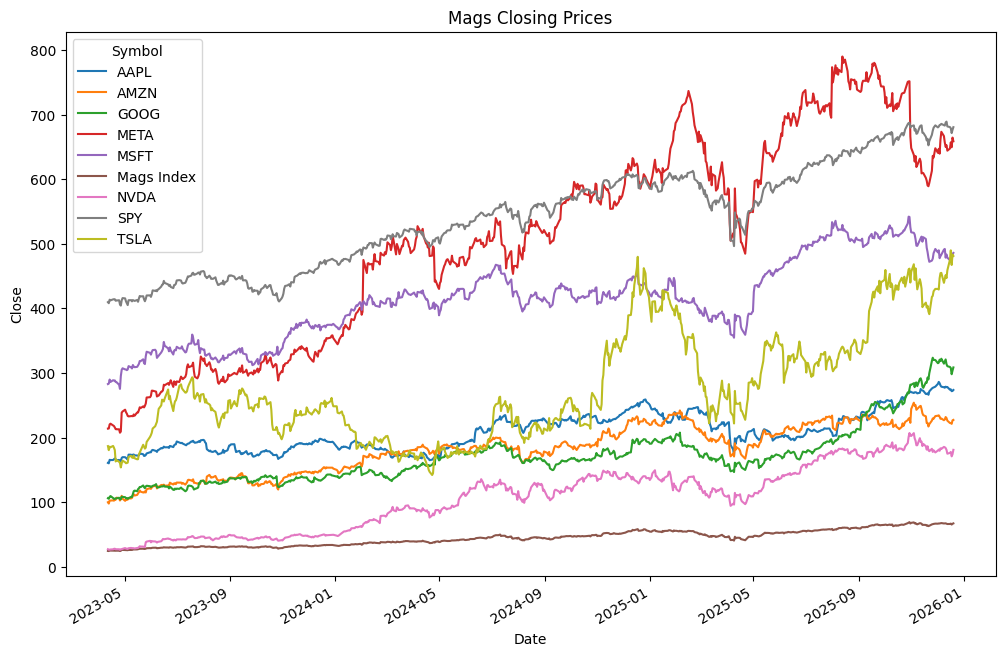

In [7]:
close.pivot_table(index=close.index, columns='Symbol', values='close').plot(title="Mags Closing Prices", xlabel="Date", ylabel="Close", figsize=(12, 8))
plt.show()

In [8]:
# Save stock info
(close.pivot_table(index=close.index, columns='Symbol', values='close')).to_csv('Close.csv')

In [9]:
# Get return info
close["Daily Returns"] = close.groupby("Symbol")["close"].pct_change()
close

,Symbol,close,Daily Returns
timestamp,,,
2023-04-11 13:30:00,Mags Index,24.466000,NaN
2023-04-12 13:30:00,Mags Index,24.330000,-0.005559
2023-04-13 13:30:00,Mags Index,25.056999,0.029881
2023-04-14 13:30:00,Mags Index,25.070000,0.000519
2023-04-17 13:30:00,Mags Index,24.955999,-0.004547
...,...,...,...
2025-12-15 14:30:00,SPY,680.729980,-0.001511
2025-12-16 14:30:00,SPY,678.869995,-0.002732
2025-12-17 14:30:00,SPY,671.400024,-0.011004


In [10]:
# All time returns
returns = close.groupby('Symbol')['close'].apply(lambda x: ((x.iloc[-1] - x.iloc[0])/x.iloc[0])*100).sort_values(ascending=False).reset_index()
returns.columns = ["Symbol", "Returns(%)"]

# returns.to_csv("Returns.csv", index=False)
returns

,Symbol,Returns(%)
0,NVDA,566.163647
1,META,208.052373
2,GOOG,190.812267
3,Mags Index,174.339916
4,TSLA,157.615520
5,AMZN,127.532036
6,MSFT,71.806398
7,AAPL,70.192791
8,SPY,66.111009


In [11]:
# Add monthly and yearly returns
close["Monthly Returns"] = close.groupby("Symbol")["close"].pct_change(periods=21)
close["Yearly Returns"] = close.groupby("Symbol")["close"].pct_change(periods=252)


daily_returns = (close.dropna(subset=["Daily Returns"]).groupby("Symbol")["Daily Returns"].mean()*100).reset_index()
returns = returns.merge(daily_returns, on="Symbol", how="left")

monthly_returns = (close.dropna(subset=["Monthly Returns"]).groupby("Symbol")["Monthly Returns"].mean()*100).reset_index()
returns = returns.merge(monthly_returns, on="Symbol", how="left")

yearly_returns = (close.dropna(subset=["Yearly Returns"]).groupby("Symbol")["Yearly Returns"].mean()*100).reset_index()
returns = returns.merge(yearly_returns, on="Symbol", how="left")

returns
#

,Symbol,Returns(%),Daily Returns,Monthly Returns,Yearly Returns
0,NVDA,566.163647,0.329464,7.066408,109.604202
1,META,208.052373,0.191462,3.895614,54.679109
2,GOOG,190.812267,0.174775,3.806806,31.142942
3,Mags Index,174.339916,0.163222,3.338436,41.415389
4,TSLA,157.615520,0.210231,4.673778,38.055847
5,AMZN,127.532036,0.141000,2.807210,31.427157
6,MSFT,71.806398,0.089969,1.769869,17.844264
7,AAPL,70.192791,0.091813,1.850625,16.031974
8,SPY,66.111009,0.079633,1.678465,20.086409


In [12]:
returns = returns.rename(columns={"Returns(%)":"All Time Return(April 23 - Pres)"})
returns

,Symbol,All Time Return(April 23 - Pres),Daily Returns,Monthly Returns,Yearly Returns
0,NVDA,566.163647,0.329464,7.066408,109.604202
1,META,208.052373,0.191462,3.895614,54.679109
2,GOOG,190.812267,0.174775,3.806806,31.142942
3,Mags Index,174.339916,0.163222,3.338436,41.415389
4,TSLA,157.615520,0.210231,4.673778,38.055847
5,AMZN,127.532036,0.141000,2.807210,31.427157
6,MSFT,71.806398,0.089969,1.769869,17.844264
7,AAPL,70.192791,0.091813,1.850625,16.031974
8,SPY,66.111009,0.079633,1.678465,20.086409


In [13]:
# Format correctly
returns = pd.melt(returns, id_vars=["Symbol"], value_vars=list(returns.columns[1:]), var_name="Return Period", value_name="Return(%)")

In [14]:
returns

,Symbol,Return Period,Return(%)
0,NVDA,All Time Return(April 23 - Pres),566.163647
1,META,All Time Return(April 23 - Pres),208.052373
2,GOOG,All Time Return(April 23 - Pres),190.812267
3,Mags Index,All Time Return(April 23 - Pres),174.339916
4,TSLA,All Time Return(April 23 - Pres),157.615520
5,AMZN,All Time Return(April 23 - Pres),127.532036
6,MSFT,All Time Return(April 23 - Pres),71.806398
7,AAPL,All Time Return(April 23 - Pres),70.192791
8,SPY,All Time Return(April 23 - Pres),66.111009
9,NVDA,Daily Returns,0.329464


In [15]:
# save
returns.to_csv("Returns.csv", index=False)

In [16]:
# Market Cap

# 1) Fetch page
url = "https://www.slickcharts.com/sp500"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
response = requests.get(url, headers=headers)
response.raise_for_status()  # stop if fetch fails

# 2) Parse HTML
soup = BeautifulSoup(response.text, "html.parser")

# 3) Locate the table
table = soup.find("table", {"class": "table table-hover table-borderless table-sm"})

# 4) Extract header labels
headers = [th.text.strip() for th in table.find("thead").find_all("th")]

# 5) Extract all rows
rows = []
for tr in table.find("tbody").find_all("tr"):
    cells = [td.text.strip() for td in tr.find_all("td")]
    rows.append(cells)

# 6) Build Market Cap DataFrame
mc = pd.DataFrame(rows, columns=headers)

# 7) Clean numeric columns
def clean_and_convert_to_float(value):
    if not isinstance(value, str):
        return value

    value = value.strip()

    # Check if the value is enclosed in parentheses, which usually indicates negative
    is_negative_from_paren = False
    if value.startswith('(') and value.endswith(')'):
        value = value[1:-1] # Remove parentheses
        is_negative_from_paren = True

    # Remove any other non-numeric characters that might remain, except for '-' and '.'
    # This also removes '%', '$', ','
    value = re.sub(r'[%$ ,]', '', value)

    # Ensure there isn't a double negative if it was like '(-0.85)'
    # If it was negative by parentheses, and the string itself starts with '-',
    # we don't need to add another '-'
    if is_negative_from_paren and not value.startswith('-'):
        value = '-' + value

    try:
        return float(value)
    except ValueError:
        return value # Return original or handle as NaN if conversion fails for some reason

for col in ["Weight", "Price", "Chg", "% Chg"]:
    mc[col] = mc[col].apply(clean_and_convert_to_float)

print(mc.head())

   #                  Company Symbol  Weight   Price   Chg  % Chg
0  1                   Nvidia   NVDA    7.39  190.53  1.92  -1.02
1  2               Apple Inc.   AAPL    6.45  273.40 -0.41  -0.15
2  3                Microsoft   MSFT    5.78  487.71 -0.31  -0.06
3  4                   Amazon   AMZN    3.97  232.52  0.14  -0.06
4  5  Alphabet Inc. (Class A)  GOOGL    3.13  313.51 -0.58  -0.18


In [17]:
# Format
mc["Group"] = mc["Symbol"].isin(MAG_7_TICKERS+["GOOGL"])
mc["Group"] = np.where(mc["Group"], mc["Symbol"], "Non-Mags")
mc

,#,Company,Symbol,Weight,Price,Chg,% Chg,Group
0,1,Nvidia,NVDA,7.39,190.53,1.92,-1.02,NVDA
1,2,Apple Inc.,AAPL,6.45,273.40,-0.41,-0.15,AAPL
2,3,Microsoft,MSFT,5.78,487.71,-0.31,-0.06,MSFT
3,4,Amazon,AMZN,3.97,232.52,0.14,-0.06,AMZN
4,5,Alphabet Inc. (Class A),GOOGL,3.13,313.51,-0.58,-0.18,GOOGL
...,...,...,...,...,...,...,...,...
498,499,DaVita,DVA,0.01,113.98,-0.43,-0.38,Non-Mags
499,500,Mosaic Company (The),MOS,0.01,24.31,0.07,-0.29,Non-Mags
500,501,Match Group,MTCH,0.01,32.54,-0.35,-1.06,Non-Mags
501,502,Lamb Weston,LW,0.01,42.15,-0.33,-0.78,Non-Mags


In [18]:
# Save data
mc.to_csv("Market_Cap.csv", index=False)

In [19]:
# Get income statement data/metrics
income_stmt = pd.DataFrame()

# Here are the most important metrics
important_rows = [
    "Total Revenue",
    "Gross Profit",
    "Operating Income",
    "Net Income Common Stockholders",
    "EBITDA",
    "Diluted EPS"
]


for ticker in MAG_7_TICKERS[1:]:
  print(f"Searching: {ticker}")

  temp = Ticker(ticker=ticker)
  temp_df = temp.yahoo_web_income_stmt

  temp_df = temp_df.loc[important_rows]
  temp_df = temp_df.reset_index()

  temp_df = temp_df.rename(columns={"index":"metric"})
  temp_df["Company"] = temp.full_name
  print(temp_df)
  print()

  income_stmt = pd.concat([income_stmt, temp_df], axis=0)

Searching: GOOG
                           metric          TTM   12/31/2024   12/31/2023  \
0                   Total Revenue  385,476,000  350,018,000  307,394,000   
1                    Gross Profit  228,095,000  203,712,000  174,062,000   
2                Operating Income  124,077,000  112,390,000   84,293,000   
3  Net Income Common Stockholders  124,251,000  100,118,000   73,795,000   
4                          EBITDA  171,744,000  135,394,000   97,971,000   
5                     Diluted EPS        10.13         8.04         5.80   

    12/31/2022   12/31/2021       Company  
0  282,836,000  257,637,000  alphabet-inc  
1  156,633,000  146,698,000  alphabet-inc  
2   74,842,000   78,714,000  alphabet-inc  
3   59,972,000   76,033,000  alphabet-inc  
4   85,160,000  103,521,000  alphabet-inc  
5         4.56         5.61  alphabet-inc  

Searching: AMZN
                           metric          TTM   12/31/2024   12/31/2023  \
0                   Total Revenue  691,330,000  63

In [20]:
# Clean Data Frame and properly format for visualizations
def clean_period(p):
    if p == "TTM":
        return "TTM"
    else:
        return p[-4:]  # extract year

id_cols = ["metric", "Company"]
long_df = income_stmt.melt(
    id_vars=["metric", "Company"],
    var_name="Period",
    value_name="Value"
)


long_df = long_df.dropna(subset=["Value"])
long_df["Value"] = (
    long_df["Value"]
    .astype(str)
    .str.replace(",", "")
    .astype(float)
)


long_df["Period"] = long_df["Period"].apply(clean_period)
long_df.Company = long_df.Company.str.title()

long_df = long_df.query('Period == "TTM"')



In [21]:
# Save results
display(long_df.head(50))
#long_df.to_csv("Income_Statement.csv", index=False)

,metric,Company,Period,Value
0,Total Revenue,Alphabet-Inc,TTM,3.854760e+08
1,Gross Profit,Alphabet-Inc,TTM,2.280950e+08
2,Operating Income,Alphabet-Inc,TTM,1.240770e+08
3,Net Income Common Stockholders,Alphabet-Inc,TTM,1.242510e+08
4,EBITDA,Alphabet-Inc,TTM,1.717440e+08
5,Diluted EPS,Alphabet-Inc,TTM,1.013000e+01
6,Total Revenue,Amazon,TTM,6.913300e+08
7,Gross Profit,Amazon,TTM,3.459820e+08
8,Operating Income,Amazon,TTM,7.620100e+07
9,Net Income Common Stockholders,Amazon,TTM,7.648200e+07


In [22]:
# Now we want to add average metrics for other compnies in sp500 to see how mags 7 compares

# Get Sp500 tickers
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

response = requests.get(url, headers=headers)
tables = pd.read_html(response.text)

sp500_tickers_df = tables[0]
sp500_tickers_df["Symbol"] = sp500_tickers_df["Symbol"].str.replace(".", "-")
tickers = sp500_tickers_df.Symbol.tolist()

In [23]:
# Revenue estimates
EXCLUDE = set(MAG_7_TICKERS + ["GOOGL"])

sp500_universe = [
    t for t in tickers
    if t not in EXCLUDE
]

sp500_universe[:4]

['MMM', 'AOS', 'ABT', 'ABBV']

In [24]:
def fetch_ttm_income_metrics(ticker):
  """Function helps scrape individual stock income data"""
  try:
    temp = Ticker(ticker=ticker)
    df = temp.yahoo_web_income_stmt

    if df is None or df.empty:
      return None

    df = df.loc[important_rows]
    df = df.reset_index().rename(columns={"index": "metric"})

    # Keep only TTM
    if "TTM" not in df.columns:
      return None

    df = df[["metric", "TTM"]]
    df = df.rename(columns={"TTM": "Value"})
    df["Value"] = (
      df["Value"]
      .astype(str)
      .str.replace(",", "")
      .astype(float)
    )

    df["Ticker"] = ticker
    return df

  except Exception as e:
    # Silent failure is OK for large universes
    return None


In [25]:
results = []

# Use threading to effectively scrape 493 income statements
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [
        executor.submit(fetch_ttm_income_metrics, t)
        for t in sp500_universe
    ]

    for future in as_completed(futures):
        res = future.result()
        if res is not None:
            results.append(res)

In [26]:
sp500_ttm_raw = pd.concat(results, ignore_index=True)
sp500_ttm_raw

,metric,Value,Ticker
0,Total Revenue,3830100.00,AOS
1,Gross Profit,1475100.00,AOS
2,Operating Income,720300.00,AOS
3,Net Income Common Stockholders,530500.00,AOS
4,EBITDA,795200.00,AOS
...,...,...,...
859,Gross Profit,6190900.00,ETR
860,Operating Income,3314339.00,ETR
861,Net Income Common Stockholders,1808937.00,ETR
862,EBITDA,6173988.00,ETR


In [27]:
sp500_avg = (
    sp500_ttm_raw
    .groupby("metric", as_index=False)["Value"]
    .mean()
)
sp500_avg["Company"] = "SP500 Avg (Ex-MAG7)"
sp500_avg["Period"] = "TTM"
sp500_avg = sp500_avg[["metric", "Company", "Period", "Value"]] # Reorder

sp500_avg

,metric,Company,Period,Value
0,Diluted EPS,SP500 Avg (Ex-MAG7),TTM,6.340278e+00
1,EBITDA,SP500 Avg (Ex-MAG7),TTM,5.692924e+06
2,Gross Profit,SP500 Avg (Ex-MAG7),TTM,9.850867e+06
3,Net Income Common Stockholders,SP500 Avg (Ex-MAG7),TTM,2.581357e+06
4,Operating Income,SP500 Avg (Ex-MAG7),TTM,3.828785e+06
5,Total Revenue,SP500 Avg (Ex-MAG7),TTM,3.128557e+07


In [28]:
# Concat with original
final_df = pd.concat(
    [long_df, sp500_avg],
    ignore_index=True
)

final_df

,metric,Company,Period,Value
0,Total Revenue,Alphabet-Inc,TTM,3.854760e+08
1,Gross Profit,Alphabet-Inc,TTM,2.280950e+08
2,Operating Income,Alphabet-Inc,TTM,1.240770e+08
3,Net Income Common Stockholders,Alphabet-Inc,TTM,1.242510e+08
4,EBITDA,Alphabet-Inc,TTM,1.717440e+08
5,Diluted EPS,Alphabet-Inc,TTM,1.013000e+01
6,Total Revenue,Amazon,TTM,6.913300e+08
7,Gross Profit,Amazon,TTM,3.459820e+08
8,Operating Income,Amazon,TTM,7.620100e+07
9,Net Income Common Stockholders,Amazon,TTM,7.648200e+07


In [29]:
# Save income statement data
final_df.to_csv("income_statement.csv", index=False)